# 2A.algo - Plus proches voisins en grande dimension - correction

La méthodes des [plus proches voisins](https://fr.wikipedia.org/wiki/Recherche_des_plus_proches_voisins) est un algorithme assez simple qui devient très lent en grande dimension. Ce notebook propose un moyen d'aller plus vite (ACP) mais en perdant un peu en performance. 

In [ ]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [ ]:
%matplotlib inline

## Q1 : k-nn : mesurer la performance

In [ ]:
import time
from sklearn.datasets import make_classification
from sklearn.neighbors import KNeighborsClassifier

def what_to_measure(n, n_features, n_classes=3, n_clusters_per_class=2, n_informative=8,
                    neighbors=5, algorithm="brute"):
    datax, datay = make_classification(n, n_features=n_features, n_classes=n_classes, 
                                       n_clusters_per_class=n_clusters_per_class, 
                                       n_informative=n_informative)
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    model.fit(datax, datay)
    t1 = time.clock()
    y = model.predict(datax)
    t2 = time.clock()
    return t2 - t1, y

In [ ]:
dt, y = what_to_measure(2000, 10)
dt

0.10705330522077405

### dimension

In [ ]:
x = []
y = []
ys = []
for nf in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
    x.append(nf)
    dt, _ = what_to_measure(5000, n_features=nf)
    y.append(dt)
    if nf <= 100:
        dt2, _ = what_to_measure(5000, n_features=nf, algorithm="ball_tree")
    else:
        dt2 = None
    ys.append(dt2)
    print("nf={0} dt={1} dt2={2}".format(nf, dt, dt2))

nf=10 dt=0.6019994840499943 dt2=0.4292384048532486
nf=20 dt=0.5500524838884142 dt2=0.7831398125750371
nf=50 dt=0.6259959000542419 dt2=1.5448688850936674
nf=100 dt=0.6438388418700143 dt2=4.1738660655414535
nf=200 dt=0.6644507680583498 dt2=None
nf=500 dt=0.7658491664009883 dt2=None
nf=1000 dt=0.8855807775832769 dt2=None
nf=2000 dt=1.2180050749569489 dt2=None
nf=5000 dt=2.158468552926159 dt2=None
nf=10000 dt=3.9253579156251845 dt2=None


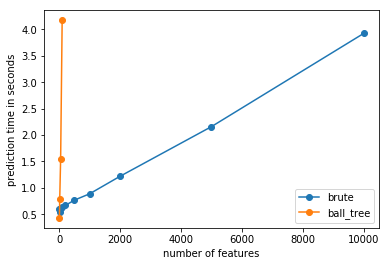

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.plot(x, ys, "o-", label="ball_tree")
ax.set_xlabel("number of features")
ax.set_ylabel("prediction time in seconds")
ax.legend()

### observations

In [ ]:
x = []
y = []
ys = []
for nobs in [1000, 2000, 5000, 10000, 12000, 15000, 17000, 20000]:
    x.append(nobs)
    dt, _ = what_to_measure(nobs, n_features=200)
    y.append(dt)
    if nobs <= 5000:
        dt2, _ = what_to_measure(nobs, n_features=200, algorithm="ball_tree")
    else:
        dt2 = None
    ys.append(dt2)
    print("nobs={0} dt={1} dt2={2}".format(nobs, dt, dt2))

nobs=1000 dt=0.04316123279656381 dt2=0.29295767748226
nobs=2000 dt=0.09993351118991356 dt2=1.391681116032256
nobs=5000 dt=0.6326372748990323 dt2=9.683458350469117
nobs=10000 dt=2.956841532632261 dt2=None
nobs=12000 dt=4.304105121060601 dt2=None
nobs=15000 dt=6.1131095943392495 dt2=None
nobs=17000 dt=7.52556105612517 dt2=None
nobs=20000 dt=15.684603238001102 dt2=None


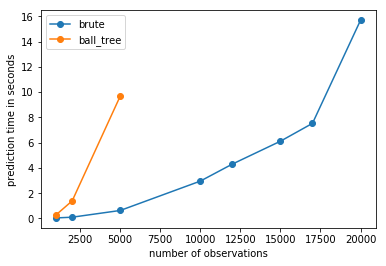

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.plot(x, ys, "o-", label="ball_tree")
ax.set_xlabel("number of observations")
ax.set_ylabel("prediction time in seconds")
ax.legend()

## Q2 : k-nn avec sparse features

On recommence cette mesure de temps mais en créant des jeux de données [sparses](https://fr.wikipedia.org/wiki/Matrice_creuse). On utilise le jeu précédent et on lui adjoint des coordonnées aléatoires et sparse. La première fonction ``random_sparse_matrix`` crée un vecteur sparse.

In [ ]:
import numpy
import numpy.random
import random
import scipy.sparse


def random_sparse_matrix(shape, ratio_sparse=0.2):
    rnd = numpy.random.rand(shape[0] * shape[1])
    sparse = 0
    for i in range(0, len(rnd)):
        x = random.random()
        if x <= ratio_sparse - sparse:
            sparse += 1 - ratio_sparse
        else:
            rnd[i] = 0
            sparse -= ratio_sparse
    rnd.resize(shape[0], shape[1])
    return scipy.sparse.csr_matrix(rnd)


mat = random_sparse_matrix((20, 20))
"% non null coefficient", 1. * mat.nnz / (mat.shape[0] * mat.shape[1]), "shape", mat.shape

('% non null coefficient', 0.2, 'shape', (20, 20))

In [ ]:
import random
from scipy.sparse import hstack

def what_to_measure_sparse(n, n_features, n_classes=3, n_clusters_per_class=2, n_informative=8,
                    neighbors=5, algorithm="brute", nb_sparse=20, ratio_sparse=0.2):
    datax, datay = make_classification(n, n_features=n_features, n_classes=n_classes, 
                                       n_clusters_per_class=n_clusters_per_class, 
                                       n_informative=n_informative)
    
    sp = random_sparse_matrix((datax.shape[0], (nb_sparse - n_features)), ratio_sparse=ratio_sparse)
    datax = hstack([datax, sp])
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    model.fit(datax, datay)
    t1 = time.clock()
    y = model.predict(datax)
    t2 = time.clock()
    return t2 - t1, y, datax.nnz / (datax.shape[0] * datax.shape[1])

In [ ]:
dt, y, sparse_ratio = what_to_measure_sparse(2000, 10, nb_sparse=100, ratio_sparse=0.2)
dt, sparse_ratio

(0.2765191784464065, 0.28)

Seul l'algorithme *brute* accepte les features sparses.

In [ ]:
x = []
y = []
nfd = 200
for nf in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
    x.append(nf)
    dt, _, ratio = what_to_measure_sparse(2000, n_features=nfd, nb_sparse=nfd+nf, 
                                   ratio_sparse=1.*nfd/(nfd+nf))
    y.append(dt)
    print("nf={0} dt={1} ratio={2}".format(nf, dt, ratio))

nf=10 dt=1.5204501486022934 ratio=0.9977333333333334
nf=20 dt=1.7614489740851411 ratio=0.9917340909090909
nf=50 dt=1.7535465636979097 ratio=0.96
nf=100 dt=1.8724837066859834 ratio=0.88889
nf=200 dt=2.00825006429622 ratio=0.75
nf=500 dt=2.029575471120438 ratio=0.4897964285714286
nf=1000 dt=1.7852292915800945 ratio=0.30555583333333336
nf=2000 dt=1.8195703866820168 ratio=0.17355363636363635
nf=5000 dt=1.6611926978457063 ratio=0.07544375
nf=10000 dt=1.7084732344021063 ratio=0.038831225490196075


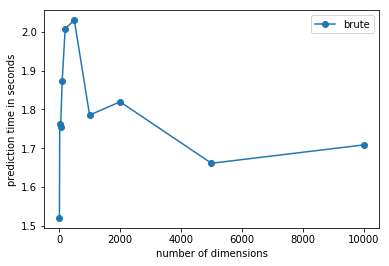

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.set_xlabel("number of dimensions")
ax.set_ylabel("prediction time in seconds")
ax.legend()

La dimension augmente mais le nombre de features non nulle est constant. Comme l'algorithme est fortement dépendant de la distance entre deux éléments et le coût de cette distance dépend du nombre de coefficients non nuls.

## Q3 : Imaginez une façon d'aller plus vite ?

Le coût d'un algorithme des plus proches voisins est linéaire selon la dimension car la majeure partie du temps est passé dans la fonction de distance et que celle-ci est linéaire. Mesurons la performance en fonction de la dimension. Ce n'est pas vraiment rigoureux de le faire dans la mesure où les données changent et n'ont pas les mêmes propriétés mais cela donnera une idée.

In [ ]:
from sklearn.model_selection import train_test_split

def what_to_measure_perf(n, n_features, n_classes=3, n_clusters_per_class=2, n_informative=8,
                    neighbors=5, algorithm="brute"):
    datax, datay = make_classification(n, n_features=n_features, n_classes=n_classes, 
                                       n_clusters_per_class=n_clusters_per_class, 
                                       n_informative=n_informative)
    X_train, X_test, y_train, y_test = train_test_split(datax, datay)
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    model.fit(X_train, y_train)
    t1 = time.clock()
    y = model.predict(X_test)
    t2 = time.clock()
    good = (y_test == y).sum() / len(datay)
    return t2 - t1, good

what_to_measure_perf(5000, 100)

(0.11310998940052741, 0.18479999999999999)

In [ ]:
x = []
y = []
for nf in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
    x.append(nf)
    dt, perf = what_to_measure_perf(5000, n_features=nf)
    y.append(perf)
    print("nf={0} perf={1} dt={2}".format(nf, perf, dt))

nf=10 perf=0.2144 dt=0.12195857150595657
nf=20 perf=0.2084 dt=0.10057272030894637
nf=50 perf=0.2094 dt=0.08913530176550921
nf=100 perf=0.1766 dt=0.11379739599328786
nf=200 perf=0.1672 dt=0.1173173918214161
nf=500 perf=0.1396 dt=0.19581724940167078
nf=1000 perf=0.1206 dt=0.2313699973888106
nf=2000 perf=0.1104 dt=0.3402820658384371
nf=5000 perf=0.0948 dt=0.7753081181533616
nf=10000 perf=0.0934 dt=1.331557928030179


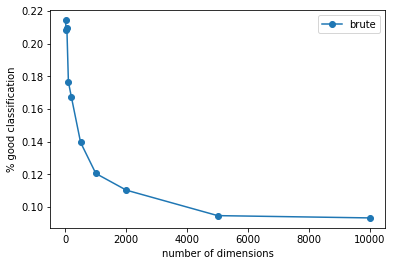

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.plot(x, y, "o-", label="brute")
ax.set_xlabel("number of dimensions")
ax.set_ylabel("% good classification")
ax.legend()

Même si les performances ne sont pas tout-à-fait comparables, il est vrai qu'il est plus difficile de construire un classifieur basé sur une distance en grande dimension. La raison est simple : plus il y a de dimensions, plus la distance devient binaire : soit les coordonnées concordent sur les mêmes dimensions, soit elles ne concordent pas et la distance est presque équivalente à la somme des carrés des coordonnées.

Revenons au problème principal. Accélérer le temps de calcul des plus proches voisins.
L'idée est d'utiliser une [ACP](https://fr.wikipedia.org/wiki/Analyse_en_composantes_principales) : l'ACP a la propriété de trouver un hyperplan qui réduit les dimensions mais qui conserve le plus possible l'inertie d'un nuage de points et on l'exprimer ainsi :

$$I = \frac{1}{n} \sum_i^n \left\Vert X_i - G \right\Vert^2 = \frac{1}{n^2} \sum_i^n\sum_j^n \left\Vert X_i - X_j \right\Vert^2$$

Bref, l'ACP conserve en grande partie les distances. Cela veut dire qu'une ACP réduit les dimensions, donc le temps de prédiction, tout en conservant le plus possible la distance entre deux points.

In [ ]:
from sklearn.decomposition import PCA

def what_to_measure_perf_acp(n, n_features, acp_dim=10,
                    n_classes=3,  n_clusters_per_class=2, n_informative=8,
                    neighbors=5, algorithm="brute"):
    datax, datay = make_classification(n, n_features=n_features, n_classes=n_classes, 
                                       n_clusters_per_class=n_clusters_per_class, 
                                       n_informative=n_informative)
    X_train, X_test, y_train, y_test = train_test_split(datax, datay)
    
    # sans ACP
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    model.fit(X_train, y_train)
    t1o = time.clock()
    y = model.predict(X_test)
    t2o = time.clock()
    goodo = (y_test == y).sum() / len(datay)
    
    # ACP
    model = KNeighborsClassifier(neighbors, algorithm=algorithm)
    pca = PCA(n_components=acp_dim)
    t0 = time.clock()
    X_train_pca = pca.fit_transform(X_train)
    model.fit(X_train_pca, y_train)
    t1 = time.clock()
    X_test_pca = pca.transform(X_test)
    y = model.predict(X_test_pca)
    t2 = time.clock()
    good = (y_test == y).sum() / len(datay)
    
    return t2o - t1o, goodo, t2 - t1, t1 - t0, good

what_to_measure_perf_acp(5000, 100)

(0.11917180937643934,
 0.19159999999999999,
 0.09498141829362794,
 0.017255880783523025,
 0.22220000000000001)

In [ ]:
x = []
y = []
yp = []
p = []
p_noacp = []
y_noacp = []
for nf in [10, 20, 50, 100, 200, 500, 1000, 2000, 5000, 10000]:
    x.append(nf)
    dt_noacp, perf_noacp, dt, dt_train, perf = what_to_measure_perf_acp(5000, n_features=nf)
    p.append(perf)
    y.append(perf)
    yp.append(dt_train)
    y_noacp.append(dt_noacp)
    p_noacp.append(perf_noacp)
    print("nf={0} perf={1} dt_predict={2} dt_train={3}".format(nf, perf, dt, dt_train))

nf=10 perf=0.2234 dt_predict=0.10264007588375534 dt_train=0.0019678001367537945
nf=20 perf=0.224 dt_predict=0.10264244625113861 dt_train=0.009018063386065478
nf=50 perf=0.2224 dt_predict=0.10190328663293258 dt_train=0.012852527977429418
nf=100 perf=0.2148 dt_predict=0.10305410008413673 dt_train=0.020230692072345846
nf=200 perf=0.2202 dt_predict=0.10624896049512245 dt_train=0.048967053076012235
nf=500 perf=0.2116 dt_predict=0.09763267441076096 dt_train=0.07658064997849579
nf=1000 perf=0.199 dt_predict=0.09247554472040065 dt_train=0.13868111958754525
nf=2000 perf=0.1912 dt_predict=0.11294327354880807 dt_train=0.26802101567864156
nf=5000 perf=0.1536 dt_predict=0.14626945627333043 dt_train=0.8286757586065505
nf=10000 perf=0.1488 dt_predict=0.1786099611535974 dt_train=1.3338382216238642


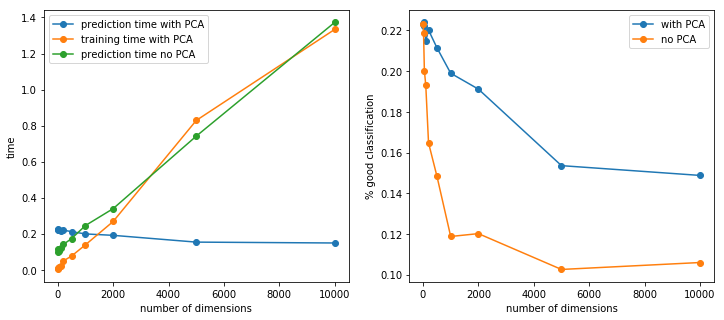

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,5))
ax[0].plot(x, y, "o-", label="prediction time with PCA")
ax[0].plot(x, yp, "o-", label="training time with PCA")
ax[0].plot(x, y_noacp, "o-", label="prediction time no PCA")
ax[0].set_xlabel("number of dimensions")
ax[0].set_ylabel("time")
ax[1].plot(x, p, "o-", label="with PCA")
ax[1].plot(x, p_noacp, "o-", label="no PCA")
ax[1].set_xlabel("number of dimensions")
ax[1].set_ylabel("% good classification")
ax[0].legend()
ax[1].legend()

Etonnament, l'ACP améliore les performances du modèle en terme de prédiction. Cela suggère que les données sont bruitées et que l'ACP en a réduit l'importance. Le calcul de l'ACP est linéaire par rapport au nombre de features. Une partie des coûts a été transférée sur l'apprentissage et le prédiction est constant car on conseerve toujours le même nombre de dimensions.